In [1]:
import torch
import matplotlib.pyplot as plt
import non_local_boxes
import numpy as np
from IPython.display import clear_output   # in order to clear the print output
import time

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')   # in ordert to have unblurred pictures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Gradient Descent

In [2]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [3]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [4]:
def gradient_descent(starting_W, P, Q, learning_rate, nb_iterations = 400, tolerance=1e-6):
    m = non_local_boxes.evaluate.nb_columns
    external_grad = torch.ones(m)
    W = starting_W
    for _ in range(nb_iterations):
        #Wold = W
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach() 
        #if (torch.max(torch.abs(W-Wold)) < tolerance):   return W
        W.requires_grad=True
    return W

### Histogram

In [5]:
PR = non_local_boxes.utils.PR
SR = non_local_boxes.utils.SR
I = non_local_boxes.utils.I

In [6]:
histogramGD = [ 0.7966312170028687,
0.8449999690055847,
0.75,
0.7499980926513672,
0.7966312170028687,
0.7960124015808105,
0.75,
0.7499994039535522,
0.7962515354156494,
0.825501561164856,
0.7500000596046448,
0.75,
0.7475000023841858,
0.8449999690055847,
0.75,
0.75,
0.7966294884681702,
0.75,
0.7966312170028687,
0.75,
0.8255008459091187,
0.8255022764205933,
0.7966299057006836,
0.75,
0.7499992251396179,
0.7499972581863403,
0.7962563037872314,
0.75,
0.75,
0.7962532639503479,
0.7966282367706299,
0.7499999403953552,
0.7499984502792358,
0.79625004529953,
0.75,
0.7499995827674866,
0.75,
0.75,
0.75,
0.7499982714653015,
0.7499983906745911,
0.75,
0.7966312170028687,
0.75,
0.7966311573982239,
0.75,
0.7966312170028687,
0.7499973177909851,
0.8449999690055847,
0.749998927116394,
0.7500000596046448,
0.75,
0.796629011631012,
0.75,
0.75,
0.75,
0.7499982118606567,
0.7499972581863403,
0.8449999690055847,
0.75,
0.7966312170028687,
0.75,
0.7962499856948853,
0.75,
0.75,
0.7966312766075134,
0.7966312766075134,
0.7962563037872314,
0.8449999690055847,
0.75,
0.7966310977935791,
0.7962563037872314,
0.8449999690055847,
0.7966312170028687,
0.7499999403953552,
0.8255010843276978,
0.7499999403953552,
0.7966312766075134,
0.7966311573982239,
0.75,
0.7499989867210388,
0.7966312170028687,
0.75,
0.8449999690055847,
0.8449999690055847,
0.7960583567619324,
0.7966312170028687,
0.7499985098838806,
0.75,
0.7499999403953552,
0.75,
0.7500000596046448,
0.7499943971633911,
0.7966302633285522,
0.7962562441825867,
0.75,
0.7966307401657104,
0.75,
0.8440249562263489,
0.75,
0.7499913573265076,
0.7499998807907104,
0.7500000596046448,
0.8449999690055847,
0.75,
0.75,
0.7499999403953552,
0.7966291904449463,
0.7962562441825867,
0.7966312170028687,
0.8255031108856201,
0.7962561845779419,
0.75,
0.75,
0.75,
0.7966312766075134,
0.75,
0.75,
0.75,
0.75,
0.8440249562263489,
0.7962563037872314,
0.7499991059303284,
0.8449999690055847,
0.75,
0.75,
0.75,
0.7966307401657104,
0.7962557077407837,
0.7962515354156494,
0.7500000596046448,
0.75,
0.75,
0.7499999403953552,
0.75,
0.75,
0.7499985694885254,
0.7499990463256836,
0.75,
0.75,
0.7966312766075134,
0.7499982118606567,
0.7966312170028687,
0.7962561845779419,
0.7962542176246643,
0.75,
0.7499947547912598,
0.7499999403953552,
0.75,
0.8255032300949097,
0.7499977946281433,
0.747499942779541,
0.7966312766075134,
0.75,
0.7499974966049194,
0.75,
0.7966312170028687,
0.7499999403953552,
0.7499960660934448,
0.75,
0.75,
0.75,
0.75,
0.7966312766075134,
0.7966312766075134,
0.7966312766075134,
0.75,
0.7500000596046448,
0.7966312170028687,
0.7966312170028687,
0.7966294884681702,
0.75,
0.8449999690055847,
0.7966301441192627,
0.7962559461593628,
0.7966295480728149,
0.825502336025238,
0.75,
0.8449999690055847,
0.7966312170028687,
0.75,
0.7962532043457031,
0.7966312170028687,
0.8449999690055847,
0.75,
0.7966300845146179,
0.7966296076774597,
0.8449999690055847,
0.8449999690055847,
0.75,
0.7966312170028687,
0.7966312766075134,
0.7966312170028687,
0.7499986886978149,
0.8449999690055847,
0.75,
0.7966312766075134,
0.7966312766075134,
0.75,
0.7499999403953552,
0.75,
0.747499942779541,
0.8449999094009399,
0.8449999690055847,
0.7966289520263672,
0.75,
0.8255020380020142,
0.7966312170028687,
0.7966311573982239,
0.7966312170028687,
0.7966306209564209,
0.7966312766075134,
0.75,
0.7966312766075134,
0.75,
0.8255025148391724,
0.7966312170028687,
0.75,
0.7962523698806763,
0.7966312170028687,
0.7962561845779419,
0.7966312170028687,
0.75,
0.7966312766075134,
0.7962561249732971,
0.75,
0.7499999403953552,
0.7966310977935791,
0.7966312170028687,
0.7499999403953552,
0.75,
0.7962562441825867,
0.7966293692588806,
0.8449999690055847,
0.8449999690055847,
0.75,
0.7966312766075134,
0.75,
0.75,
0.7499991655349731,
0.7966312766075134,
0.7499982118606567,
0.7966312170028687,
0.7962499856948853,
0.7966302037239075,
0.7499986886978149,
0.75,
0.7962561845779419,
0.7499999403953552,
0.7500000596046448,
0.75,
0.7962561845779419,
0.75,
0.75,
0.8255032300949097,
0.7499971389770508,
0.75,
0.7960124611854553,
0.7496618628501892,
0.7962562441825867,
0.8255035877227783,
0.75,
0.7962563037872314,
0.7960124611854553,
0.75,
0.7966312766075134,
0.7966311573982239,
0.7966312766075134,
0.8449999690055847,
0.75,
0.7962561249732971,
0.7966312170028687,
0.7966312170028687,
0.825502336025238,
0.75,
0.7962563037872314,
0.8255025148391724,
0.7499999403953552,
0.7499973773956299,
0.7966312170028687,
0.7499971985816956,
0.75,
0.7962554693222046,
0.75,
0.8255027532577515,
0.7966312170028687,
0.75,
0.7966312170028687,
0.75,
0.7499985694885254,
0.7499977946281433,
0.7499992251396179,
0.8449999690055847,
0.7966290712356567,
0.7960124611854553,
0.7499974966049194,
0.75,
0.7966312170028687,
0.7966312170028687,
0.75,
0.7499985694885254,
0.7500000596046448,
0.7966307997703552,
0.75,
0.75,
0.8449999094009399,
0.8255015015602112,
0.75,
0.75,
0.7499982118606567,
0.7962563037872314,
0.7962557077407837,
0.8420374393463135,
0.7499999403953552,
0.8255015015602112,
0.7499994039535522,
0.7962561845779419,
0.8449999690055847,
0.7962561249732971,
0.7966312766075134,
0.7962561845779419,
0.8425250053405762,
0.7500000596046448,
0.75,
0.7499999403953552,
0.8449999690055847,
0.75,
0.75,
0.8255046606063843,
0.8255012035369873,
0.7962499260902405,
0.75,
0.75,
0.75,
0.75,
0.7962547540664673,
0.8440249562263489,
0.7475000619888306,
0.75,
0.7966312170028687,
0.7962554693222046,
0.7966310977935791,
0.7966306209564209,
0.7966289520263672,
0.8255029320716858,
0.7499979734420776,
0.8449999690055847,
0.7966312170028687,
0.75,
0.7966293096542358,
0.75,
0.75,
0.7966312766075134,
0.7966312766075134,
0.7966312766075134,
0.75,
0.8255014419555664,
0.7960123419761658,
0.75,
0.7966311573982239,
0.8432750105857849,
0.8450000286102295,
0.8450000286102295,
0.8450000286102295,
0.8255013227462769,
0.75,
0.75,
0.7966294288635254,
0.75,
0.7500000596046448,
0.7499971985816956,
0.75,
0.75,
0.7966312766075134,
0.75,
0.8449999690055847,
0.75,
0.7500000596046448,
0.8255023956298828,
0.75,
0.8255043029785156,
0.7962499260902405,
0.8255007266998291,
0.7966312170028687,
0.7499932050704956,
0.7966299653053284,
0.75,
0.8255033493041992,
0.75,
0.7966285943984985,
0.75,
0.8255053758621216,
0.75,
0.75,
0.75,
0.7966312766075134,
0.7499973773956299,
0.8449999690055847,
0.75,
0.8449999094009399,
0.7499989867210388,
0.7966299057006836,
0.7966291904449463,
0.8255017995834351,
0.75,
0.75,
0.75,
0.8449999690055847,
0.75,
0.8255017995834351,
0.75,
0.75,
0.7966312766075134,
0.7499999403953552,
0.75,
0.75,
0.7966312170028687,
0.75,
0.75,
0.75,
0.75,
0.75,
0.79625004529953,
0.7499999403953552,
0.75,
0.7966312766075134,
0.8255026340484619,
0.75,
0.7966312170028687,
0.8449999690055847,
0.7499997615814209,
0.7962563037872314,
0.75,
0.75,
0.75,
0.7966312170028687,
0.8440249562263489,
0.8449999690055847,
0.75,
0.7962562441825867,
0.8255020380020142,
0.7962561845779419,
0.7499984502792358,
0.7966309189796448,
0.7966312170028687,
0.8255025148391724,
0.7499980926513672,
0.75,
0.7966312170028687,
0.7945250868797302,
0.75,
0.7966312170028687,
0.7966112494468689,
0.7966291308403015,
0.7966312766075134,
0.8440249562263489,
0.8255030512809753,
0.7966312766075134,
0.7966313362121582,
0.75,
0.8255013823509216,
0.7966312766075134,
0.7966311573982239,
0.7966309189796448,
0.75,
0.7966311573982239,
0.75,
0.7499999403953552,
0.7499927878379822,
0.7966312170028687,
0.7499972581863403,
0.7962561845779419,
0.749997079372406,
0.7962545156478882,
0.7499999403953552,
0.8449999690055847,
0.7962521314620972,
0.7500001192092896,
0.7966312170028687,
0.75,
0.7500000596046448,
0.7499983906745911,
0.8255032300949097,
0.8255027532577515,
0.7966312170028687,
0.7966312766075134,
0.7499992847442627,
0.7966311573982239,
0.7962563037872314,
0.75,
0.8255053758621216,
0.8450000286102295,
0.825503408908844,
0.7966312766075134,
0.7966312170028687,
0.8255032300949097,
0.7499997615814209,
0.75,
0.8449999690055847,
0.825505256652832,
0.7500000596046448,
0.75,
0.7962561845779419,
0.75,
0.75,
0.7499992251396179,
0.7962562441825867,
0.75,
0.7966296672821045,
0.7962561845779419,
0.7966304421424866,
0.75,
0.75,
0.8449999690055847,
0.7962499260902405,
0.8255044221878052,
0.75,
0.7957624197006226,
0.7966309189796448,
0.75,
0.7966305613517761,
0.7499991655349731,
0.7966307997703552,
0.7960124611854553,
0.7962562441825867,
0.75,
0.75,
0.7966312170028687,
0.8255010843276978,
0.7966312170028687,
0.8255013227462769,
0.75,
0.7960124611854553,
0.7499994039535522,
0.796629011631012,
0.7966312766075134,
0.7962561845779419,
0.7966295480728149,
0.7966302037239075,
0.7962541580200195,
0.8425250053405762,
0.75,
0.75,
0.7499999403953552,
0.75,
0.8255009651184082,
0.75,
0.7962561845779419,
0.7966312766075134,
0.7500000596046448,
0.8255041837692261,
0.75,
0.7499978542327881,
0.7966311573982239,
0.75,
0.75,
0.8449999690055847,
0.75,
0.7499991059303284,
0.7966303825378418,
0.7499979734420776,
0.7499995827674866,
0.8449999690055847,
0.75,
0.8255023956298828,
0.75,
0.75,
0.7962562441825867,
0.8255029916763306,
0.7499994039535522,
0.75,
0.75,
0.749997615814209,
0.75,
0.8449999690055847,
0.8440249562263489,
0.8440249562263489,
0.8712875247001648,
0.749999463558197,
0.7475062012672424,
0.7499986886978149,
0.7966309785842896,
0.7499988079071045,
0.75,
0.75,
0.7962563037872314,
0.7499999403953552,
0.7500000596046448,
0.7500000596046448,
0.7966312170028687,
0.7966312170028687,
0.75,
0.75,
0.7962554693222046,
0.75,
0.75,
0.75,
0.7966312170028687,
0.7499979734420776,
0.7499994039535522,
0.75,
0.75,
0.75,
0.7962563037872314,
0.7966312170028687,
0.7499977350234985,
0.8255017995834351,
0.8425249457359314,
0.7966312766075134,
0.7966309189796448,
0.75,
0.7966282963752747,
0.75,
0.75,
0.7966298460960388,
0.75,
0.7966312170028687,
0.7962533831596375,
0.7499999403953552,
0.7960124015808105,
0.7962562441825867,
0.75,
0.75,
0.75,
0.7960124611854553,
0.7962562441825867,
0.7962560653686523,
0.7966312170028687,
0.7966285943984985,
0.7962552905082703,
0.75,
0.75,
0.7962532043457031,
0.75,
0.7962561249732971,
0.7962561845779419,
0.75,
0.75,
0.7475000023841858,
0.8255013227462769,
0.7499999403953552,
0.7962562441825867,
0.7499999403953552,
0.796629011631012,
0.7966312170028687,
0.7966288924217224,
0.8255017995834351,
0.75,
0.7962561845779419,
0.8449999690055847,
0.75,
0.7966309189796448,
0.75,
0.75,
0.7962561845779419,
0.7500000596046448,
0.7960125207901001,
0.75,
0.7499999403953552,
0.7962561845779419,
0.7966312170028687,
0.7499974966049194,
0.8449999690055847,
0.7499979734420776,
0.7966312170028687,
0.7966305017471313,
0.7500000596046448,
0.749998927116394,
0.7966312766075134,
0.75,
0.7499999403953552,
0.75,
0.7499999403953552,
0.75,
0.75,
0.7962563037872314,
0.8255024552345276,
0.749998927116394,
0.8255029916763306,
0.8255043625831604,
0.75,
0.75,
0.7475062608718872,
0.7966312766075134,
0.7962562441825867,
0.7966310977935791,
0.8255027532577515,
0.8449999690055847,
0.7966312766075134,
0.7966306805610657,
0.75,
0.7499927878379822,
0.8449999690055847,
0.7966312170028687,
0.7499982118606567,
0.7966309189796448,
0.7499971389770508,
0.7962559461593628,
0.7499982714653015,
0.7500000596046448,
0.7499973773956299,
0.8255014419555664,
0.7966302037239075,
0.7962561845779419,
0.8255009055137634,
0.75,
0.7966289520263672,
0.7962562441825867,
0.7966312766075134,
0.7499968409538269,
0.75,
0.75,
0.75,
0.75,
0.75,
0.75,
0.7962499856948853,
0.75,
0.7499992251396179,
0.7499986886978149,
0.75,
0.8255029916763306,
0.75,
0.7500000596046448,
0.7966312170028687,
0.75,
0.7499960064888,
0.7962542772293091,
0.8449999690055847,
0.75,
0.7962554693222046,
0.7499973177909851,
0.7499993443489075,
0.75,
0.7966312766075134,
0.75,
0.75,
0.75,
0.75,
0.7966312766075134,
0.7966312170028687,
0.7966312170028687,
0.75,
0.75,
0.796630859375,
0.7499995827674866,
0.7966312766075134,
0.7966294884681702,
0.75,
0.8255023956298828,
0.7966312170028687,
0.7962561845779419,
0.75,
0.75,
0.75,
0.7962561845779419,
0.7966312766075134,
0.7966312766075134,
0.7966312766075134,
0.75,
0.75,
0.7499971985816956,
0.7966312766075134,
0.7966298460960388,
0.7966312766075134,
0.8255035877227783,
0.7499985098838806,
0.7962563037872314,
0.75,
0.7499980926513672,
0.75,
0.7966287136077881,
0.75,
0.7962562441825867,
0.7966312766075134,
0.7499994039535522,
0.8255028128623962,
0.75,
0.7966312170028687,
0.75,
0.7966312170028687,
0.75,
0.7962561845779419,
0.7966296076774597,
0.8450000286102295,
0.7962562441825867,
0.7966312766075134,
0.825501561164856,
0.7962562441825867,
0.75,
0.75,
0.75,
0.7962562441825867,
0.7962558269500732,
0.7499992847442627,
0.7962562441825867,
0.7966311573982239,
0.8440249562263489,
0.75,
0.75,
0.75,
0.75,
0.7962561249732971,
0.75,
0.75,
0.75,
0.7966293096542358,
0.8255038261413574,
0.7966307401657104,
0.7962515354156494,
0.75,
0.75,
0.7966312766075134,
0.8255007863044739,
0.75,
0.7499993443489075,
0.7966312170028687,
0.8449999094009399,
0.749998927116394,
0.8432750105857849,
0.75,
0.75,
0.7966302037239075,
0.7966312766075134,
0.75,
0.7499999403953552,
0.8255012631416321,
0.7499996423721313,
0.75,
0.7966312766075134,
0.75,
0.7499995231628418,
0.75,
0.7499971389770508,
0.8449999690055847,
0.7962532639503479,
0.7962523698806763,
0.75,
0.75,
0.8449999690055847,
0.8255029916763306,
0.75,
0.75,
0.8432749509811401,
0.749998152256012,
0.7966292500495911,
0.75,
0.7500000596046448,
0.75,
0.75,
0.7499987483024597,
0.7962562441825867,
0.8449999690055847,
0.75,
0.7966312170028687,
0.8255034685134888,
0.75,
0.7966312170028687,
0.8255029916763306,
0.7499976754188538,
0.7962562441825867,
0.7499999403953552,
0.75,
0.75,
0.75,
0.7966312170028687,
0.8255020380020142,
0.8449999690055847,
0.8440249562263489,
0.8449999690055847,
0.7499982118606567,
0.7500000596046448,
0.7962499856948853,
0.7499999403953552,
0.75,
0.7960125207901001,
0.7966312170028687,
0.75,
0.75,
0.75,
0.75,
0.8255010843276978,
0.7966312170028687,
0.7966312170028687,
0.7966304421424866,
0.75,
0.8255021572113037,
0.8449999690055847,
0.8440249562263489,
0.7962499856948853,
0.7499989867210388,
0.75,
0.75,
0.75,
0.7499979734420776,
0.75,
0.7966312766075134,
0.75,
0.75,
0.75,
0.7962562441825867,
0.7499999403953552,
0.75,
0.8425250053405762,
0.75,
0.7962563037872314,
0.7966312170028687,
0.7500000596046448,
0.75,
0.749998927116394,
0.7966302037239075,
0.8449999690055847,
0.7962562441825867,
0.75,
0.75,
0.8449999690055847,
0.7966299057006836,
0.7966312170028687,
0.7962554693222046,
0.7966312766075134,
0.749997615814209,
0.7499999403953552,
0.7966312170028687,
0.7966312170028687,
0.7966312170028687,
0.7962561845779419,
0.7499999403953552,
0.75,
0.75,
0.7957624793052673,
0.7966307401657104,
0.7966311573982239,
0.7962499856948853,
0.8255013823509216,
0.75,
0.7966312170028687,
0.7962563037872314,
0.8440249562263489,
0.7499985098838806,
0.75,
0.7962532043457031,
0.8449999690055847,
0.75,
0.7499996423721313,
0.7966312170028687,
0.75,
0.7966306209564209,
0.75,
0.75,
0.7499998807907104,
0.7962526082992554,
0.8449999690055847,
0.8449999690055847,
0.8255029320716858,
0.8449999690055847,
0.8449999690055847,
0.75,
0.75,
0.8255032300949097,
0.7966288328170776,
0.75,
0.75,
0.7966312170028687,
0.7966312170028687,
0.7966291904449463,
0.75,
0.8449999690055847,
0.7499983310699463,
0.75,
0.7477270364761353,
0.7500000596046448,
0.7499977946281433,
0.7962561845779419,
0.7499967217445374,
0.8440249562263489,
0.75,
0.7966312766075134,
0.7962562441825867,
0.75,
0.8712874054908752,
0.75,
0.7966312170028687,
0.7966312170028687,
0.7966312170028687,
0.7962547540664673,
0.7957624793052673,
0.75,
0.75,
0.7962562441825867,
0.7962499856948853,
0.75,
0.7962508201599121,
0.75,
0.7966312170028687,
0.75,
0.75,
0.75,
0.7966312170028687,
0.8450000286102295,
0.7499977946281433
 ]

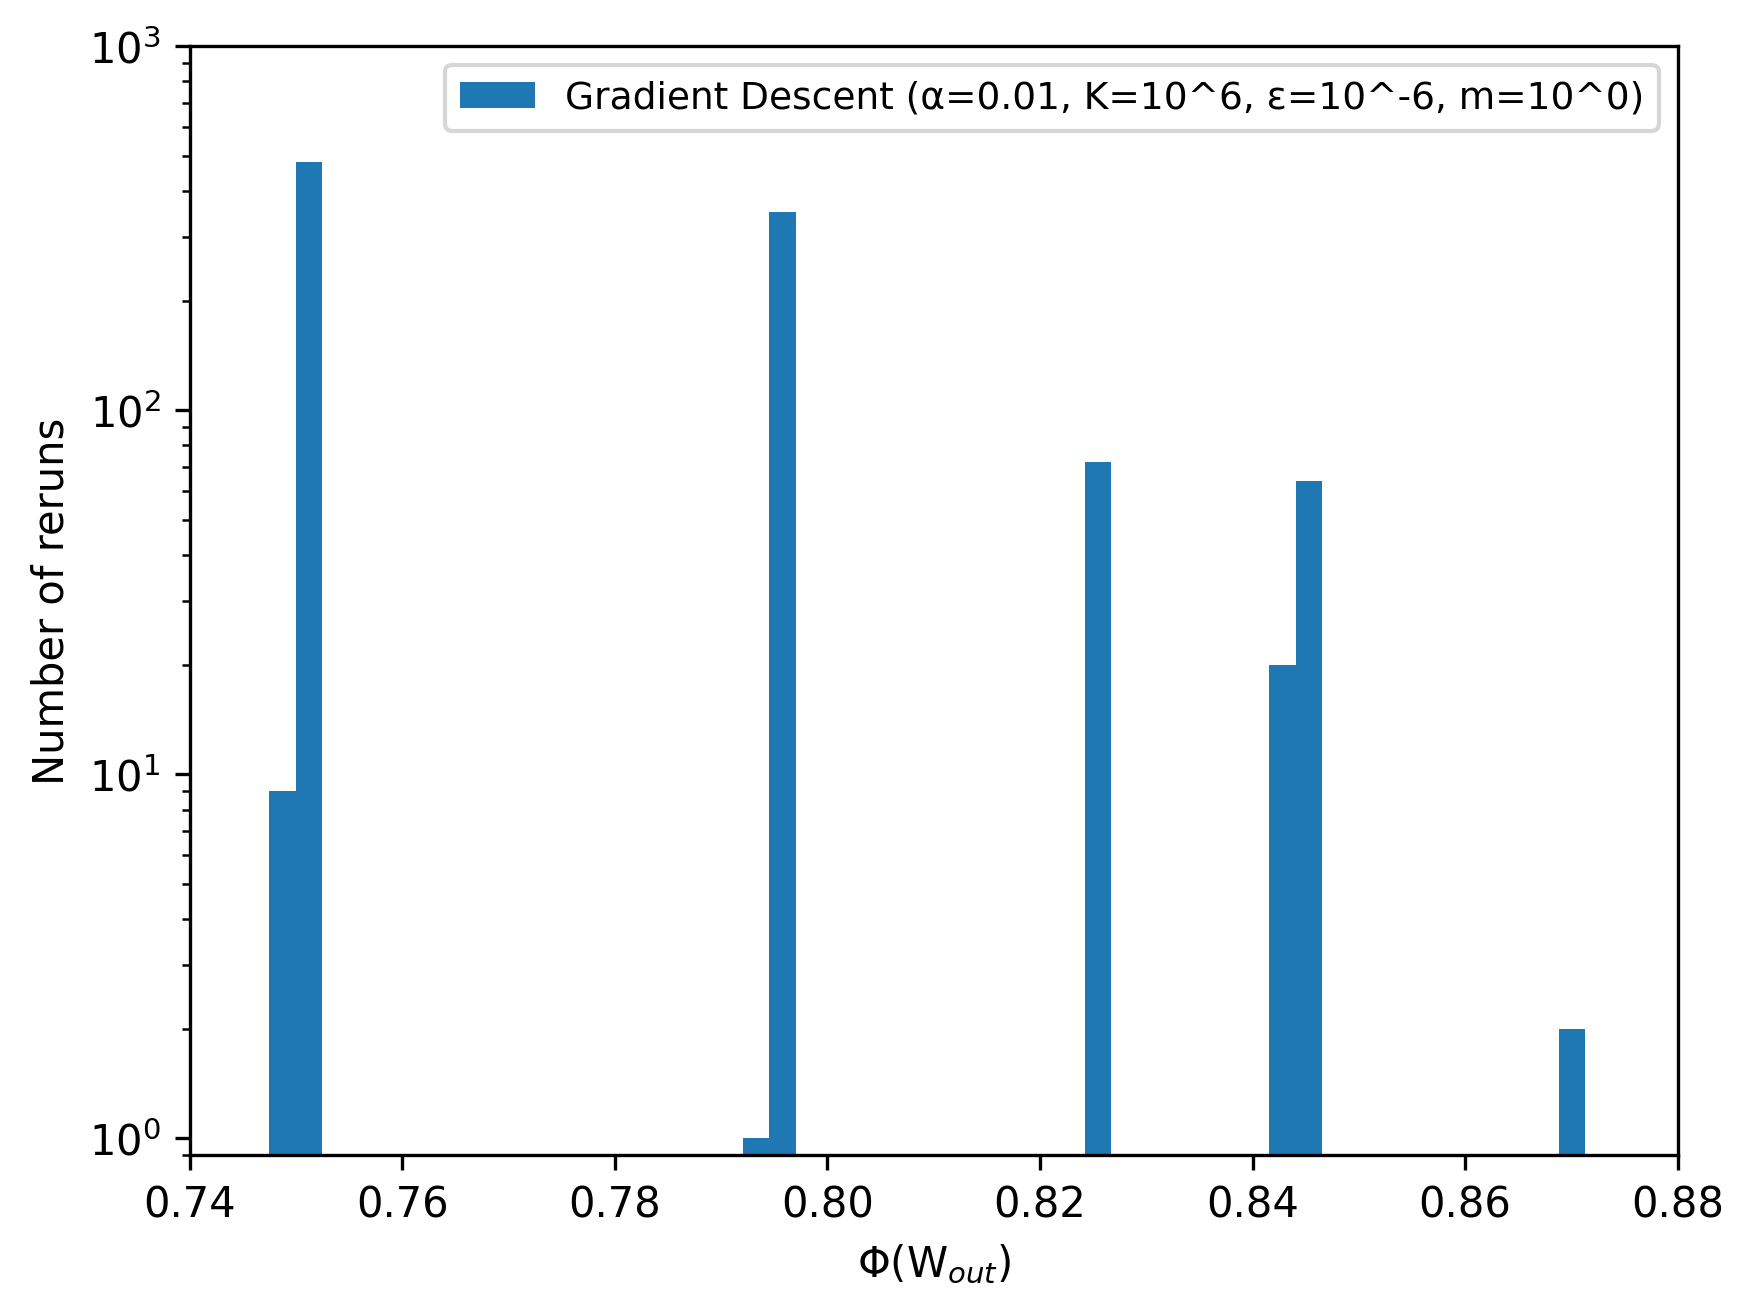

In [7]:
p=0.39
q=0.6
P = p*PR +q*SR + (1-p-q)*I
BoxProduct = non_local_boxes.evaluate.phi_flat

m = non_local_boxes.evaluate.nb_columns
alpha = 0.01
K=int(1e6) # puissance 6
epsilon=1e-6

# W = gradient_descent(
#     starting_W=non_local_boxes.utils.random_wiring(m),
#     P=P,
#     Q=P,
#     learning_rate=alpha,
#     nb_iterations=K,
#     tolerance=epsilon
# )
# histogramGD = BoxProduct(W, P, P).tolist()

#plt.hist(histogramGD, bins=50, label="Gradient Descent (p="+str(p)+", q="+str(q)+", α="+str(alpha)+", K="+str(K)+", m=10^"+str(int(np.log10(m)))+", ε=10^"+str(int(np.log10(epsilon)))+")")
plt.hist(histogramGD, bins=50, label="Gradient Descent (α="+str(alpha)+", K=10^"+str(int(np.log10(K)))+", ε=10^"+str(int(np.log10(epsilon)))+", m=10^"+str(int(np.log10(m)))+")")
#plt.xlabel("CHSH-value")
plt.xlim(0.74, 0.88)
plt.ylim(0.9, int(1e3))
plt.xlabel("$\Phi(\mathsf{W}_{{out}})$")
plt.ylabel("Number of reruns")
plt.yscale("log")
plt.legend(fontsize="9")
#plt.title("Histogram of the different results with a random initialization (with $\mathbf{P}=(\mathbf{PR}+\mathbf{SR})/2$, total: "+str(N)+" occurences)")
plt.show()

In [8]:
for j in range(len(histogramGD)):
    print(str(histogramGD[j])+",")

0.7966312170028687,
0.8449999690055847,
0.75,
0.7499980926513672,
0.7966312170028687,
0.7960124015808105,
0.75,
0.7499994039535522,
0.7962515354156494,
0.825501561164856,
0.7500000596046448,
0.75,
0.7475000023841858,
0.8449999690055847,
0.75,
0.75,
0.7966294884681702,
0.75,
0.7966312170028687,
0.75,
0.8255008459091187,
0.8255022764205933,
0.7966299057006836,
0.75,
0.7499992251396179,
0.7499972581863403,
0.7962563037872314,
0.75,
0.75,
0.7962532639503479,
0.7966282367706299,
0.7499999403953552,
0.7499984502792358,
0.79625004529953,
0.75,
0.7499995827674866,
0.75,
0.75,
0.75,
0.7499982714653015,
0.7499983906745911,
0.75,
0.7966312170028687,
0.75,
0.7966311573982239,
0.75,
0.7966312170028687,
0.7499973177909851,
0.8449999690055847,
0.749998927116394,
0.7500000596046448,
0.75,
0.796629011631012,
0.75,
0.75,
0.75,
0.7499982118606567,
0.7499972581863403,
0.8449999690055847,
0.75,
0.7966312170028687,
0.75,
0.7962499856948853,
0.75,
0.75,
0.7966312766075134,
0.7966312766075134,
0.7962563037872

# Line Search

$$
\left\{
\begin{array}{l}
    \alpha^*_k = \argmax_\alpha \phi(x_k + \alpha \nabla \phi(x_k))\\
    x_{k+1}= \texttt{proj}(x_k + \alpha^*_k \nabla \phi(x_k))
\end{array}
\right.
$$

In [9]:
def reorder_list(L, phi):
    j=0
    while j<len(L):
        if j!=0 and phi[L[j-1]]<phi[L[j]]:
            L[j-1],L[j]=L[j],L[j-1]
            j-=2
        j+=1
    return L

In [10]:
phi=[0.1, 0.3, 0, 10, 9, 0.5]
L = [*range(len(phi))]
L = reorder_list(L, phi)
print([phi[k] for k in L])

[10, 9, 0.5, 0.3, 0.1, 0]


In [11]:
def select_best_columns(W, P, Q, integer):
    if integer==0: return non_local_boxes.utils.random_wiring(m).detach()
    # L is the list of the "best" indexes of the columns of W
    # At the begining, we take the first indexes of W
    # We will change the list L by comparing the value at the other indexes
    # When we add a term to L, we also remove the "worst" one, and we re-order the list L
    L = [*range(integer)]
    # phi is the list of values:
    phi= non_local_boxes.evaluate.phi_flat(W,P,Q).tolist()
    # we re-order the list L:
    L = reorder_list(L, phi)
    for i in range(integer,non_local_boxes.evaluate.nb_columns):
        if phi[i]>phi[L[-1]]:
            L[-1]=i # we remove and replace the worst index
            L = reorder_list(L, phi)

    W_new = non_local_boxes.utils.random_wiring(m).detach()
    for k in range(integer):
        W_new[:,L[k]] = W[:,L[k]] # we keep only the best ones

    return W_new

In [12]:
# def line_search_with_resets(P, Q, LS_iterations, K_reset, chi):
#     m = non_local_boxes.evaluate.nb_columns
#     phi_flat = non_local_boxes.evaluate.phi_flat
#     #W = non_local_boxes.utils.random_wiring(m)
#     W = torch.zeros(32,m)
#     external_grad = torch.ones(m)
#     Krange=range(K_reset)
#     LSrange=range(LS_iterations)
    
#     for j in range(0,int(1/chi)):
#         # Reset:
#         W = select_best_columns(W, P, Q, min(m, int(j*m*chi))).detach()
#         W.requires_grad=True

#         # At the end, we do a lot of steps:
#         if j==int(1/chi)-1: Krange=range(10*K_reset)

#         # Line search:
#         for _ in Krange:
#             phi_flat(W, P, Q).backward(gradient=external_grad)
#             gradient=W.grad
#             alpha = torch.ones(m)*0.01
#             for _ in LSrange:
#                 Gains = phi_flat(W, P, Q)
#                 Gains_new = phi_flat(W + alpha*gradient, P, Q)
#                 mask = 0.0 + (Gains>Gains_new)
#                 alpha = 0.5*mask*alpha + 1.7*(1-mask)*alpha
#             W = projected_wiring(W + alpha*gradient).detach()
#             W.requires_grad=True

#     return W

In [ ]:
def line_search_with_resets(P, Q, LS_iterations, K_reset, chi):
    m = non_local_boxes.evaluate.nb_columns
    phi_flat = non_local_boxes.evaluate.phi_flat
    W, external_grad = torch.zeros(32,m), torch.ones(m)
    Krange, LSrange = range(K_reset), range(LS_iterations)
    
    for j in range(0,int(1/chi)):
        # Reset some of the wirings:
        W = select_best_columns(W, P, Q, min(m, int(j*m*chi))).detach()
        W.requires_grad=True

        # At the end, we do a lot of steps:
        if j==int(1/chi)-1:  Krange=range(10*K_reset)

        # Line search:
        for _ in Krange:
            phi_flat(W, P, Q).backward(gradient=external_grad)
            gradient=W.grad
            alpha = torch.ones(m)*0.01
            Gains = phi_flat(W, P, Q)
            Gains_futur = phi_flat(W + alpha*gradient, P, Q)
            for _ in LSrange:
                mask = 0.0 + (Gains>Gains_futur)
                alpha = 0.8*mask*alpha + 1.3*(1-mask)*alpha
                Gains = torch.max(Gains, Gains_futur)
                Gains_futur = phi_flat(W + alpha*gradient, P, Q)
            W = projected_wiring(W + alpha*gradient).detach()
            W.requires_grad=True

    return W

In [13]:
histogramLS = [ 0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8450000286102295,
0.8620249629020691,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8449999690055847,
0.8620249629020691,
0.8450000286102295,
0.8450000286102295,
0.8712874054908752,
0.8712875247001648,
0.8620249629020691,
0.8712875247001648,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8450000286102295,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8450000286102295,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.8620249629020691,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8449999690055847,
0.8449999690055847,
0.8620249629020691,
0.8620249629020691,
0.87128746509552,
0.8712874054908752,
0.8450000286102295,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.8712874054908752,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8620249629020691,
0.87128746509552,
0.8620249032974243,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8450000286102295,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.8450000286102295,
0.8449999690055847,
0.8712875247001648,
0.8620249629020691,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8620249032974243,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8620249629020691,
0.8712875247001648,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8449999690055847,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.8449999690055847,
0.8712875247001648,
0.8449999690055847,
0.8449999690055847,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8620249629020691,
0.87128746509552,
0.8450000882148743,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8450000286102295,
0.8712875247001648,
0.8449999690055847,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8712875247001648,
0.8449999690055847,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8712875247001648,
0.8712875247001648,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.8620249629020691,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.8620249629020691,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8620249629020691,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.8712874054908752,
0.8712875247001648,
0.8449999690055847,
0.8712874054908752,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.8450000286102295,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.8449999690055847,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8449999690055847,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8450000286102295,
0.8449999690055847,
0.8712875247001648,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.8712874054908752,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8449999690055847,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.8620249629020691,
0.8620249629020691,
0.8620249629020691,
0.8450000286102295,
0.8712874054908752,
0.8449999690055847,
0.8620249629020691,
0.8449999690055847,
0.8449999690055847,
0.8449999690055847,
0.8449999690055847,
0.8450000286102295,
0.8712874054908752,
0.8252833485603333,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.8449999690055847,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.8620249629020691,
0.8620249032974243,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.8712874054908752,
0.8450000286102295,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8450000882148743,
0.87128746509552,
0.8620249629020691,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8449999690055847,
0.8449999690055847,
0.8712875247001648,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8449999690055847,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8450000286102295,
0.8712875247001648,
0.8712875247001648,
0.8712874054908752,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8620249629020691,
0.8712874054908752,
0.8250348567962646,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8450000286102295,
0.8712875247001648,
0.8449999690055847,
0.8449999690055847,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8450000286102295,
0.8712874054908752,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.8450000286102295,
0.87128746509552,
0.8450000286102295,
0.8712875247001648,
0.8712874054908752,
0.8450000286102295,
0.8450000286102295,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8620249629020691,
0.8450000286102295,
0.8620249032974243,
0.8712875247001648,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.7966312170028687,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8432749509811401,
0.87128746509552,
0.8450000286102295,
0.7961683869361877,
0.8449999690055847,
0.8449999690055847,
0.8450000286102295,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.8712874054908752,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8449999690055847,
0.8450000286102295,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8449999690055847,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.7962558269500732,
0.87128746509552,
0.87128746509552,
0.79642653465271,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.8449999690055847,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8711637854576111,
0.8712874054908752,
0.8620249629020691,
0.8712874054908752,
0.87128746509552,
0.8449999690055847,
0.8449999690055847,
0.8450000286102295,
0.8449999690055847,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.87128746509552,
0.8620249629020691,
0.8712874054908752,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.8450000882148743,
0.8712874054908752,
0.8450000286102295,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8449999690055847,
0.8449999690055847,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8450000286102295,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.8450000286102295,
0.87128746509552,
0.8620249629020691,
0.8450000286102295,
0.8712875247001648,
0.8712874054908752,
0.8712875247001648,
0.8450000286102295,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8450000286102295,
0.87128746509552,
0.8712875247001648,
0.8450000286102295,
0.8712874054908752,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8712875247001648,
0.8712875247001648,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8425250053405762,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8440249562263489,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8450000286102295,
0.8712875247001648,
0.87128746509552,
0.8620249629020691,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8450000286102295,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8440249562263489,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8449999690055847,
0.7965418696403503,
0.8712875247001648,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.8620249629020691,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8450000286102295,
0.8440249562263489,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.8620249629020691,
0.8712875247001648,
0.8712874054908752,
0.8620249629020691,
0.8712875247001648,
0.87128746509552,
0.8449999690055847,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.8712875247001648,
0.8712875247001648,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8712182641029358,
0.8712875247001648,
0.7966305613517761,
0.8712874054908752,
0.8712874054908752,
0.8712874054908752,
0.8450000286102295,
0.8450000286102295,
0.8712875247001648,
0.87128746509552,
0.8450000286102295,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712875247001648,
0.8620249032974243,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.87128746509552
 ]

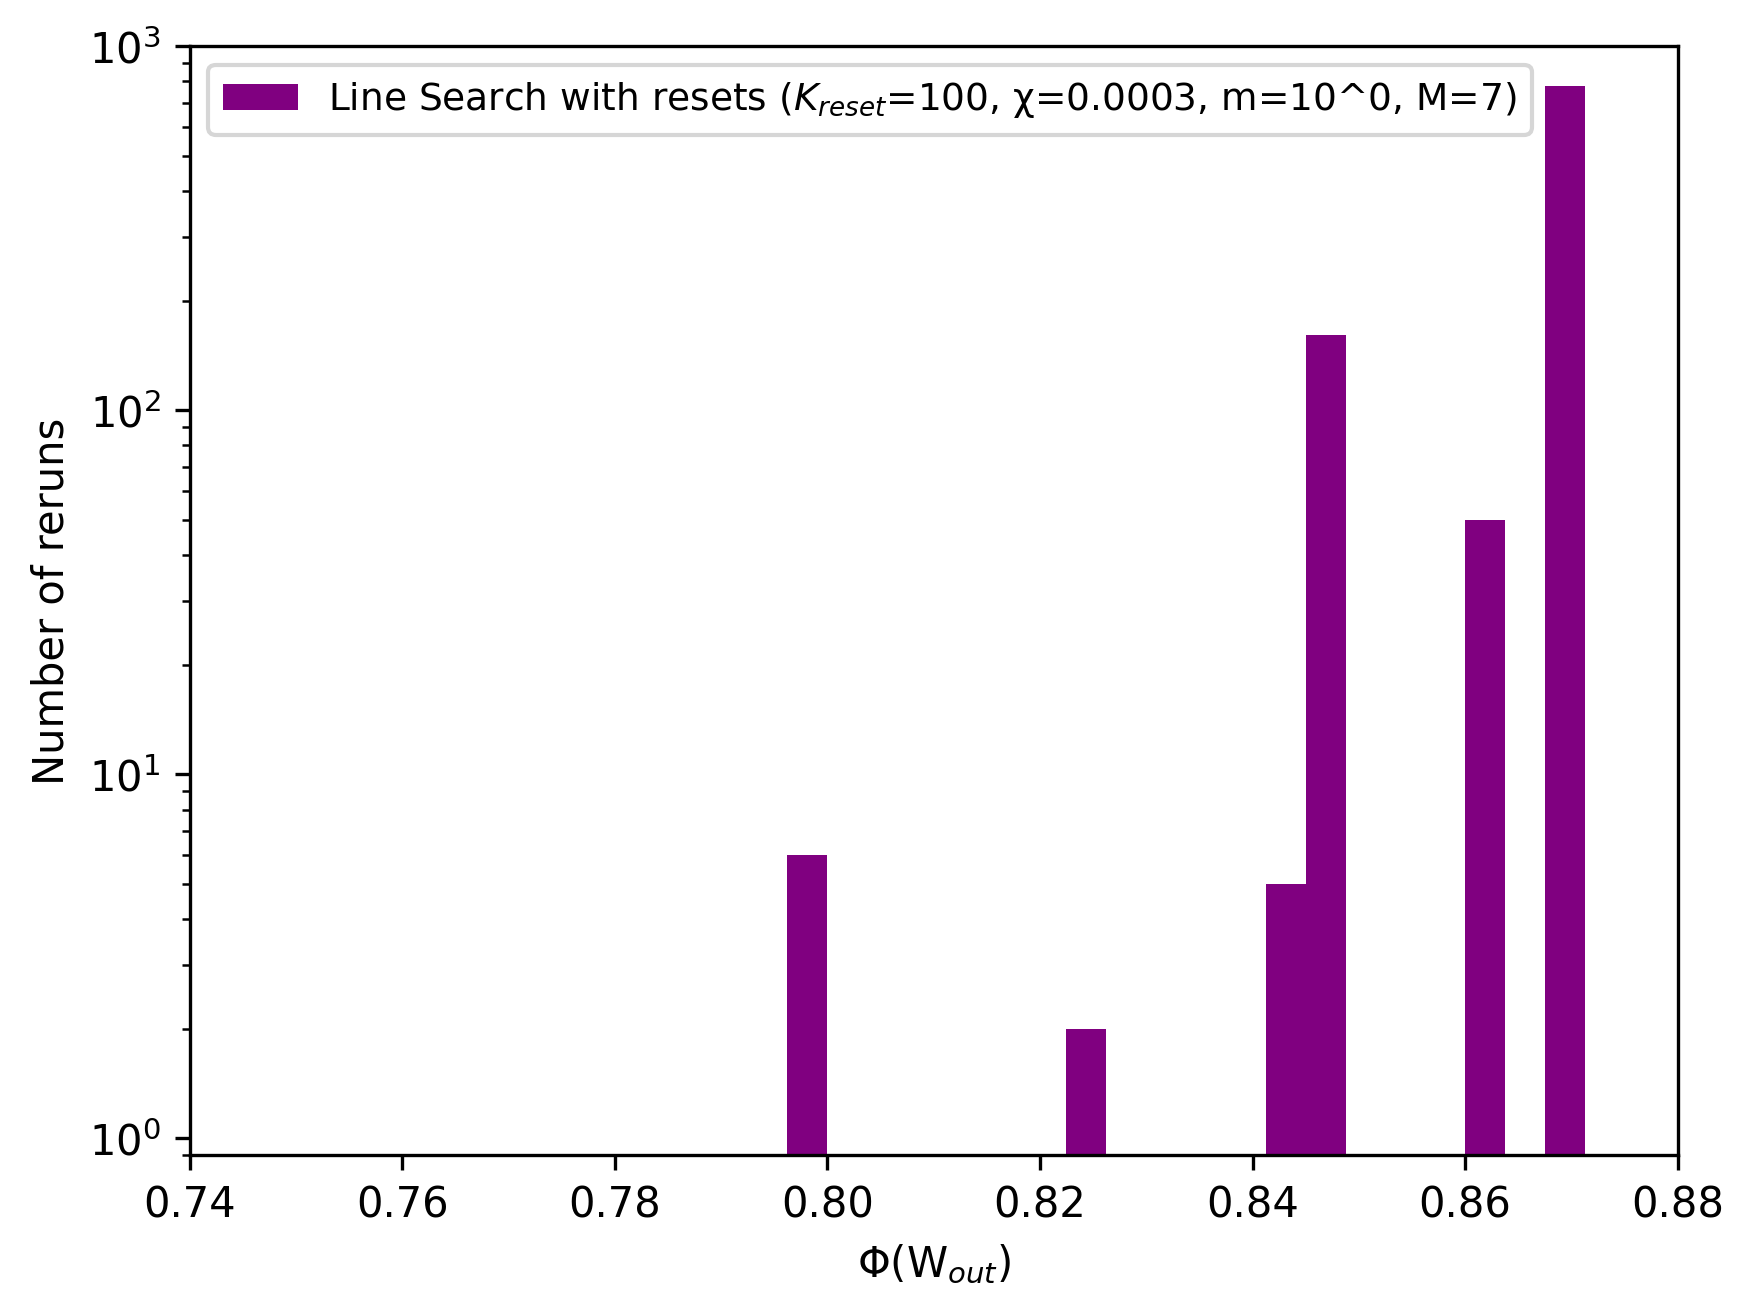

In [14]:
p=0.39
q=0.6
P = p*PR +q*SR + (1-p-q)*I
BoxProduct = non_local_boxes.evaluate.phi_flat

m = non_local_boxes.evaluate.nb_columns
K_reset=100
chi = 0.0003
LS_iterations = 7

# W=line_search_with_resets(
#     P, 
#     P, 
#     LS_iterations=LS_iterations, 
#     K_reset=K_reset, 
#     chi=chi
#     )
# histogramLS = BoxProduct(W, P, P).tolist()

#plt.hist(histogramGD, bins=50, label="Gradient Descent (p="+str(p)+", q="+str(q)+", α="+str(alpha)+", K="+str(K)+", m=10^"+str(int(np.log10(m)))+", ε=10^"+str(int(np.log10(epsilon)))+")")
plt.hist(histogramLS, bins=20, color='purple', label="Line Search with resets ($K_{reset}$="+str(K_reset)+", χ="+str(chi)+", m=10^"+str(int(np.log10(m)))+", M="+str(LS_iterations)+")")
#plt.xlabel("CHSH-value")
plt.xlim(0.74, 0.88)
plt.ylim(0.9, int(1e3))
plt.xlabel("$\Phi(\mathsf{W}_{{out}})$")
plt.ylabel("Number of reruns")
plt.yscale("log")
plt.legend(fontsize="9")
#plt.title("Histogram of the different results with a random initialization (with $\mathbf{P}=(\mathbf{PR}+\mathbf{SR})/2$, total: "+str(N)+" occurences)")
plt.show()

In [15]:
for j in range(len(histogramLS)):
    print(str(histogramLS[j])+",")

0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.8450000286102295,
0.8712874054908752,
0.8449999690055847,
0.8712875247001648,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8712874054908752,
0.8712875247001648,
0.87128746509552,
0.8450000286102295,
0.8620249629020691,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.8449999690055847,
0.8620249629020691,
0.8450000286102295,
0.8450000286102295,
0.8712874054908752,
0.8712875247001648,
0.8620249629020691,
0.8712875247001648,
0.87128746509552,
0.8449999690055847,
0.87128746509552,
0.8450000286102295,
0.87128746509552,
0.87128746509552,
0.8620249629020691,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.87128746509552,
0.8712874054908752,
0.8712874054908752,
0.8449999690055847,
0.87128746509552,
0.8712875247001648,
0.87128746509552,
0.8712874054908752,
0.87128746509552,
0.87128746509552,
0.

-----

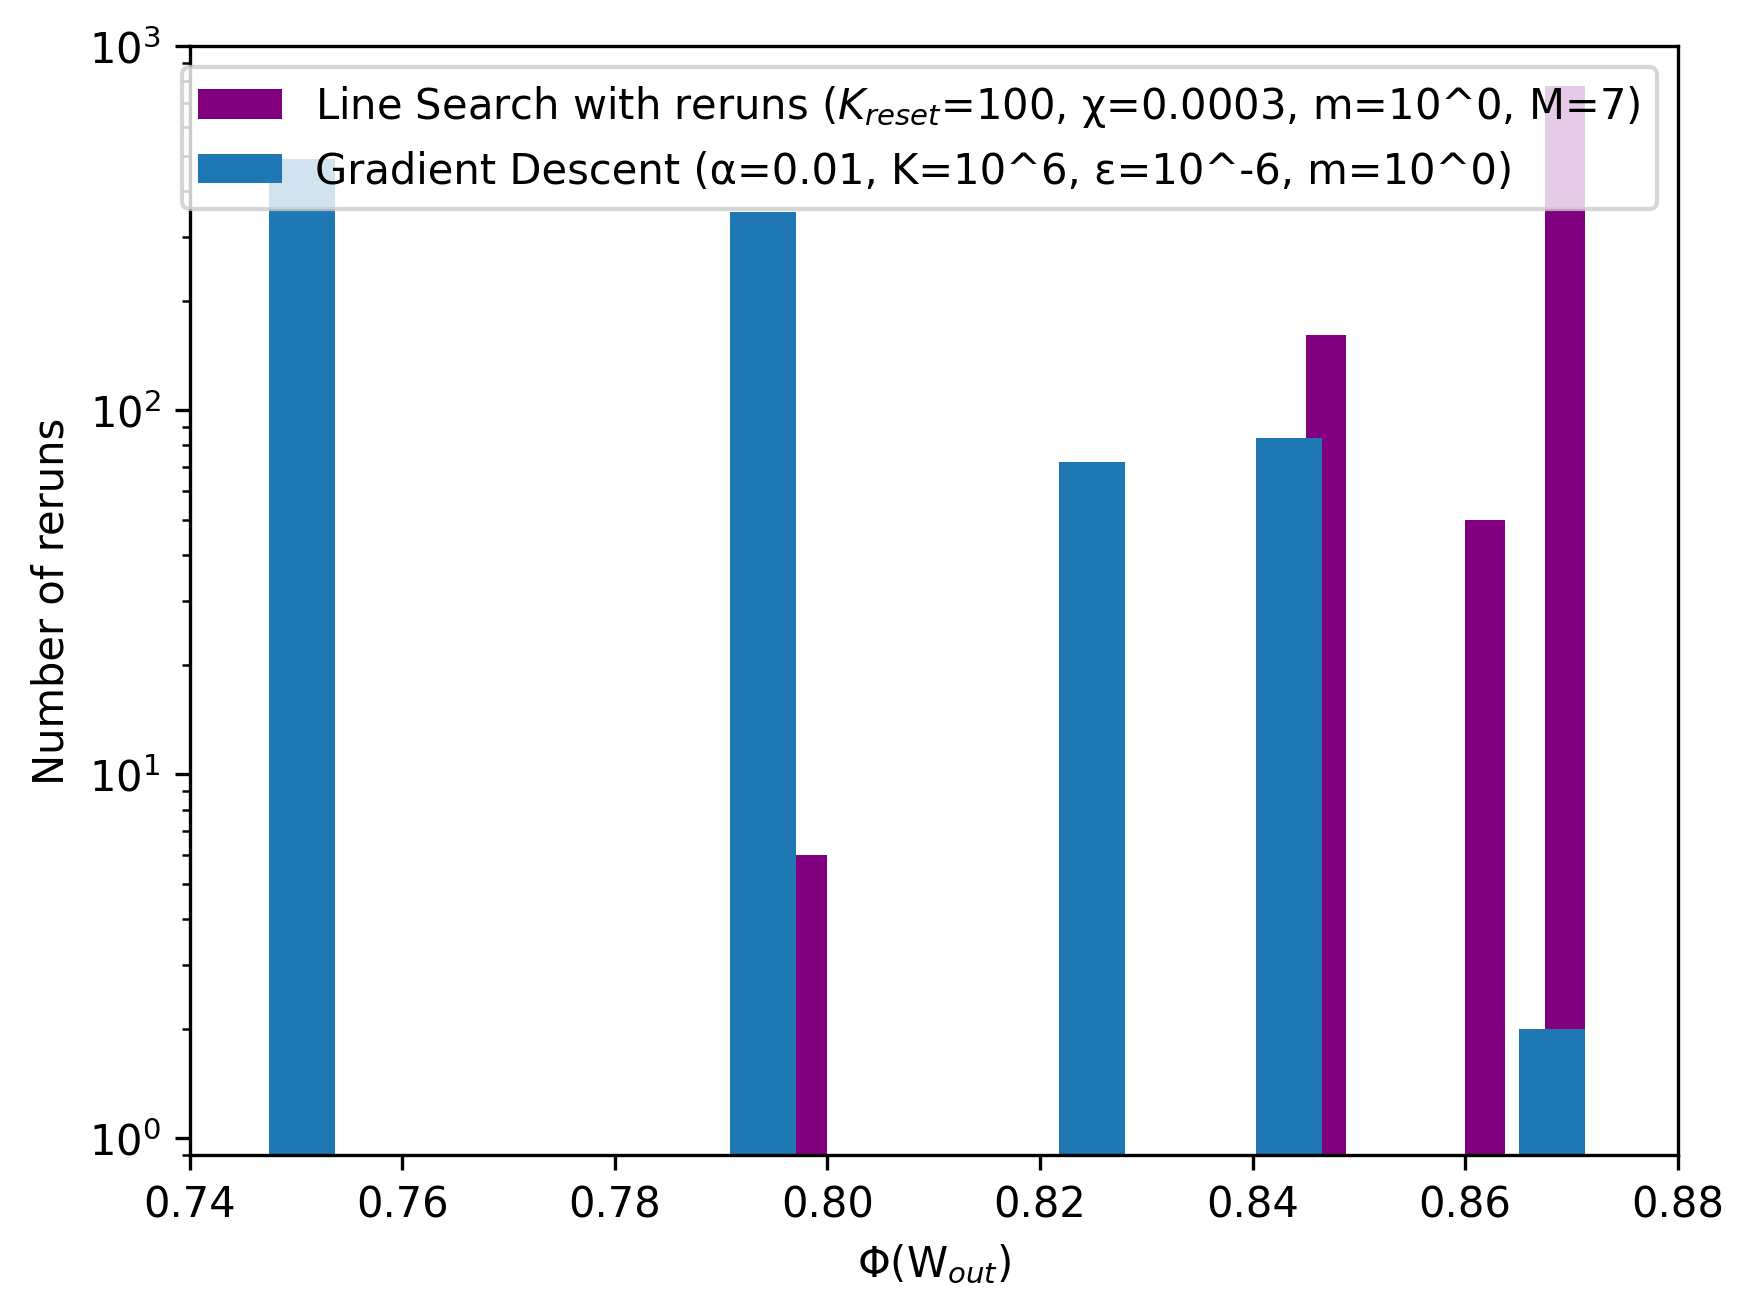

In [16]:
plt.hist(histogramLS, bins=20, color='purple', label="Line Search with reruns ($K_{reset}$="+str(K_reset)+", χ="+str(chi)+", m=10^"+str(int(np.log10(m)))+", M="+str(LS_iterations)+")")
plt.hist(histogramGD, bins=20, label="Gradient Descent (α="+str(alpha)+", K=10^"+str(int(np.log10(K)))+", ε=10^"+str(int(np.log10(epsilon)))+", m=10^"+str(int(np.log10(m)))+")")
plt.xlim(0.74, 0.88)
plt.ylim(0.9, int(1e3))
plt.xlabel("$\Phi(\mathsf{W}_{{out}})$")
plt.ylabel("Number of reruns")
plt.yscale("log")
plt.legend()
plt.show()

-----
## Saving

In [17]:
def line_search_with_resets(P, Q, LS_iterations, K_reset, chi, K, epsilon=1e-6):
    m = non_local_boxes.evaluate.nb_columns
    phi_flat = non_local_boxes.evaluate.phi_flat
    W = non_local_boxes.utils.random_wiring(m)
    external_grad = torch.ones(m)
    
    for j in range(1,int(1/chi)+1):
        # reset
        for _ in range(K_reset):
            # line search 
            phi_flat(W, P, Q).backward(gradient=external_grad)
            Wgrad = W.grad
            alpha = torch.ones(m)*0.01
            for _ in range(LS_iterations):
                Gains = phi_flat(W, P, Q)
                Gains_new = phi_flat(W + alpha*Wgrad, P, Q)
                mask = 0.0 + (Gains>Gains_new)
                alpha = 0.5*mask*alpha + 1.7*(1-mask)*alpha
            W = projected_wiring(W + alpha*Wgrad).detach()
            W.requires_grad=True
        W = select_best_columns(W, P, Q, min(m, int(j*m*chi))).detach()
        W.requires_grad=True
    
    #W = gradient_descent(W, P, Q, alpha*0.1, nb_iterations = K, tolerance=epsilon)

    return W